In [68]:
import argparse
import os
import os.path
import ctypes
from shutil import rmtree, move
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import model
import dataloader
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [130]:
CHECKPOINT = '/home/rajivratn/devansh/Super-SloMo/SuperSloMo.ckpt'
BatchSize=1
sf=7
# Initialize dataloader
def load_output(path):
    data_path = path
    ds = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    loader = torch.utils.data.DataLoader(
        ds,
        batch_size=64,
        num_workers=0,
        shuffle=False
    )
    return loader

In [131]:
def run(image_folder):
    # Path to dataset folder containing video first and last frame and output
    OutputPath = "/home/rajivratn/devansh/Super-SloMo/testData/{}/interpolated".format(image_folder)
    writeTo = "/home/rajivratn/devansh/Super-SloMo/testData/{}/interpolated/out".format(image_folder)
    readFrom = "/home/rajivratn/devansh/Super-SloMo/testData/{}/initial/in".format(image_folder)
    InputPath = "/home/rajivratn/devansh/Super-SloMo/testData/{}/initial".format(image_folder)
    # Path to folder for saving checkpoints


    # Initialize transforms
    device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

    mean = [0.429, 0.431, 0.397]
    std  = [1, 1, 1]
    normalize = transforms.Normalize(mean=mean,
                                     std=std)

    negmean = [x * -1 for x in mean]
    revNormalize = transforms.Normalize(mean=negmean, std=std)

    # Temporary fix for issue #7 https://github.com/avinashpaliwal/Super-SloMo/issues/7 -
    # - Removed per channel mean subtraction for CPU.
    if (device == "cpu"):
        transform = transforms.Compose([transforms.ToTensor()])
        TP = transforms.Compose([transforms.ToPILImage()])
    else:
        transform = transforms.Compose([transforms.ToTensor(), normalize])
        TP = transforms.Compose([revNormalize, transforms.ToPILImage()])

    # Load data
    videoFrames = dataloader.Video(root=readFrom, transform=transform)
    videoFramesloader = torch.utils.data.DataLoader(videoFrames, batch_size=2, shuffle=False)

    # Initialize model
    flowComp = model.UNet(6, 4)
    flowComp.to(device)
    for param in flowComp.parameters():
        param.requires_grad = False
    ArbTimeFlowIntrp = model.UNet(20, 5)
    ArbTimeFlowIntrp.to(device)
    for param in ArbTimeFlowIntrp.parameters():
        param.requires_grad = False

    flowBackWarp = model.backWarp(videoFrames.dim[0], videoFrames.dim[1], device)
    flowBackWarp = flowBackWarp.to(device)

    dict1 = torch.load(CHECKPOINT, map_location='cpu')
    ArbTimeFlowIntrp.load_state_dict(dict1['state_dictAT'])
    flowComp.load_state_dict(dict1['state_dictFC'])

    # Interpolate frames
    frameCounter = 1

    with torch.no_grad():
        for _, (frame0, frame1) in enumerate(tqdm(videoFramesloader), 0):

            I0 = frame0.to(device)
            I1 = frame1.to(device)

            flowOut = flowComp(torch.cat((I0, I1), dim=1))
            F_0_1 = flowOut[:,:2,:,:]
            F_1_0 = flowOut[:,2:,:,:]

            # Save reference frames in output folder
            for batchIndex in range(BatchSize):
                (TP(frame0[batchIndex].detach())).resize(videoFrames.origDim, Image.BILINEAR).save(os.path.join(writeTo, str(frameCounter + sf * batchIndex) + ".png"))
            frameCounter += 1

    #         Generate intermediate frames
            for intermediateIndex in range(1, sf):
                t = float(intermediateIndex) / sf
                temp = -t * (1 - t)
                fCoeff = [temp, t * t, (1 - t) * (1 - t), temp]

                F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
                F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

                g_I0_F_t_0 = flowBackWarp(I0, F_t_0)
                g_I1_F_t_1 = flowBackWarp(I1, F_t_1)

                intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))

                F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
                F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
                V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
                V_t_1   = 1 - V_t_0

                g_I0_F_t_0_f = flowBackWarp(I0, F_t_0_f)
                g_I1_F_t_1_f = flowBackWarp(I1, F_t_1_f)

                wCoeff = [1 - t, t]

                Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)

                # Save intermediate frame
                for batchIndex in range(BatchSize):
                    (TP(Ft_p[batchIndex].cpu().detach())).resize(videoFrames.origDim, Image.BILINEAR).save(os.path.join(writeTo, str(frameCounter + sf * batchIndex) + ".png"))
                frameCounter += 1

            # Set counter accounting for batching of frames
            frameCounter += sf * (BatchSize - 1)
    
    batch = next(iter(load_output(OutputPath)))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=10)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    batch = next(iter(load_output(InputPath)))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=10)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid, (1,2,0)))


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


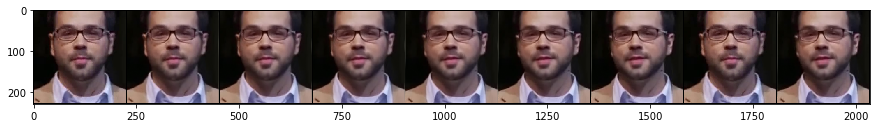

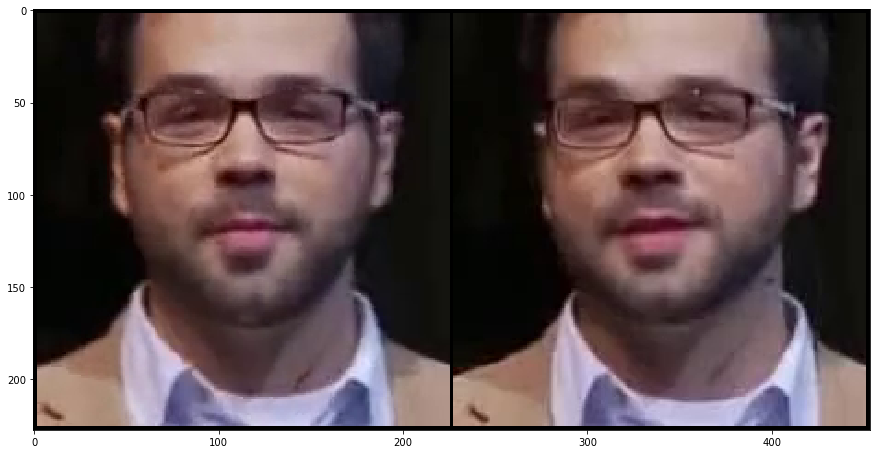

In [133]:
run("rand_1")